In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Installing Dependencies
!pip install tweet-preprocessor                                                   # https://github.com/s/preprocessor
!pip install emoji                                                                # https://github.com/carpedm20/emoji/
!pip install transformers                                                         # https://github.com/huggingface/transformers
!conda install -c saidozcan tweet-preprocessor                                    # Installation of tweet-preprocessor for Conda env
!pip install plotly-express                                                       # https://plotly.com/python/plotly-express/
!pip install pyyaml==5.4.1                                                        # Plotly-express installs pyyaml new version so we need to downgrade it for plotly to run on collab
                                                                                  # Once installed we need to just restart the kernel once and we can start importing thereafter

     |████████████████████████████████| 175 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=0bd3a6eb02337b3956cd4f36af3c00f8d865ec07b32a5ac8d5d9243f982cf6e6
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
     |████████████████████████████████| 4.0 MB 5.0 MB/s 
     |████████████████████████████████| 596 kB 42.9 MB/s 
     |████████████████████████████████| 77 kB 4.8 MB/s 
     |████████████████████████████████| 6.6 MB 35.1 MB/s 
     |████████████████████████████████| 895 kB 42.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
/bin/bash: conda: command not found
     |████████████████████████████████| 636 kB 5.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalle

In [3]:
import preprocessor as p                                                          # https://github.com/s/preprocessor
import numpy as np                                                                # https://numpy.org
import pandas as pd                                                               # https://pandas.pydata.org
import emoji                                                                      # https://github.com/carpedm20/emoji/
import keras                                                                      # https://keras.io
from sklearn.model_selection import train_test_split                              # https://scikit-learn.org/stable/
import tensorflow as tf                                                           # https://www.tensorflow.org
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU,SimpleRNN
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import plotly.graph_objects as go                                                 # https://plotly.com
import plotly.express as px
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers                                                               # https://huggingface.co/docs/transformers/index
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tqdm import tqdm
import matplotlib.pyplot as plt                                                   # https://matplotlib.org
import plotly.graph_objects as go
import seaborn as sns                                                             # https://seaborn.pydata.org
from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
import tensorflow as tf
from sklearn.metrics import confusion_matrix

                  

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## Phase I - Text Analysis using Twitter Dataset

In [4]:
# Twitter Dataset for training Text Analysis Model 
text_data = pd.read_csv('/content/drive/MyDrive/Emotional_messenger/text/text_emotion.csv')

In [5]:
# Checking Misspelled words in data

misspell_data = pd.read_csv("/content/drive/MyDrive/Emotional_messenger/text/aspell.txt",sep=":",names=["correction","misspell"]) #Text document with some major used misspelled dataset to replace https://www.kaggle.com/datasets/bittlingmayer/spelling
misspell_data.misspell = misspell_data.misspell.str.strip()                       # Stripping spaces from starting and ending
misspell_data.misspell = misspell_data.misspell.str.split(" ")                    # Splitting words by space
misspell_data = misspell_data.explode("misspell").reset_index(drop=True)          # Dropping the misspell and adjusting the index
misspell_data.drop_duplicates("misspell",inplace=True)                            # Duplicate removla
miss_corr = dict(zip(misspell_data.misspell, misspell_data.correction))           # Putting all in a dict to replace word by word in dataset
# miss_corr

In [6]:
# Printing first 5 values from miss_corr for display

f5p = {k: miss_corr[k] for k in list(miss_corr)[:5]}
f5p

{'Steffen': 'Stephen',
 'nevade': 'Nevada',
 'presbyterian': 'Presbyterian',
 'rsx': 'RSX',
 'susan': 'Susan'}

In [7]:
# Creating a function to replace all the words from dataset with misspelled words dict created above (miss_corr)

def misspelled_correction(val):
    for x in val.split(): 
        if x in miss_corr.keys(): 
            val = val.replace(x, miss_corr[x]) 
    return val

text_data["clean_content"] = text_data.content.apply(lambda x : misspelled_correction(x))

In [8]:
# Same process for replacing all the contactions using contraction dataset 

contractions = pd.read_csv("/content/drive/MyDrive/Emotional_messenger/text/contractions.csv")
cont_dic = dict(zip(contractions.Contraction, contractions.Meaning))             # Moving all entries to a dict to replace in data

In [9]:
# Printing first 5 values from cont_dic for display

f5p = {k: cont_dic[k] for k in list(cont_dic)[:5]}
f5p 

{"'aight": 'alright',
 "ain't": 'is not',
 "amn't": 'am not',
 "aren't": 'are not',
 "can't": 'cannot'}

In [10]:
# Creating a function to replace all the words from dataset with misspelled words dataset created above (cont_dic)

def cont_to_meaning(val): 
  
    for x in val.split(): 
        if x in cont_dic.keys(): 
            val = val.replace(x, cont_dic[x]) 
    return val

text_data.clean_content = text_data.clean_content.apply(lambda x : cont_to_meaning(x))

In [11]:
# Removing Hyperlink

p.set_options(p.OPT.MENTION, p.OPT.URL)
print("Printing example of Preprocessor below:\n")
print("Origional string : Affective Computing @Angelica #machine_learning CMPT724 https://canvas.sfu.ca/courses/68760")
print(f'Converted to : {p.clean("Affective Computing @Angelica #machine_learning CMPT724 https://canvas.sfu.ca/courses/68760")}')
text_data["clean_content"]=text_data.content.apply(lambda x : p.clean(x))

Printing example of Preprocessor below:

Origional string : Affective Computing @Angelica #machine_learning CMPT724 https://canvas.sfu.ca/courses/68760
Converted to : Affective Computing #machine_learning CMPT724


In [12]:
# Removing Punctuation form Regex Entry replacement into the dataset

def punctuation(val): 
  
    punctuations = '''()-[]{};:'"\,<>./@#$%^&_~'''
  
    for x in val.lower(): 
        if x in punctuations: 
            val = val.replace(x, " ") 
    return val

In [13]:
# Testing Punctuation function 

print("Origional Text :  @ () {} [] <> ldfldlf???~~~ !! ") 
print(f'Converted to : {punctuation("@ () {} [] <>  ldfldlf???~~~ !! ")}')

Origional Text :  @ () {} [] <> ldfldlf???~~~ !! 
Converted to :                ldfldlf???    !! 


In [14]:
# Removing Emojis from the dataset https://pypi.org/project/emoji/#description 

import emoji
text_data.clean_content = text_data.clean_content.apply(lambda x : ' '.join(punctuation(emoji.demojize(x)).split()))

In [15]:
# Putting all togeather in one function to be used before tokenization

def clean_text(val):
    val = misspelled_correction(val)
    val = cont_to_meaning(val)
    val = p.clean(val)
    val = ' '.join(punctuation(emoji.demojize(val)).split())
    
    return val

In [16]:
# Trying clean_text function 

clean_text("isn't 💡 adultry @ttt good bad ... ! ? ")

'is not light bulb adultery good bad ! ?'

In [17]:
# Cleaning any empty comments

text_data = text_data[text_data.clean_content != ""]

In [18]:
# Number of samples for each emotion in dataset

print("Occurance of various emotions in the dataset :")
text_data['sentiment'].value_counts()
# data[data['sentiment'] == 'empty']                # Visualize each emotion with total rows

Occurance of various emotions in the dataset :


neutral       8579
worry         8454
happiness     5208
sadness       5162
love          3841
surprise      2187
fun           1776
relief        1526
hate          1323
empty          815
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [19]:
# Since we need to make a basic 6 emotion model, we are converging some of the secondary emotions to their corresponding emotion
# and also we will be removing some of the emotion as they do not have much data available for model to train better.
# Our Basic emotions : anger, disgust, surprised, happy, fear, neutral, sad
# 1. We are dropping all empty emotions as manually checking the content says that the emotion are mixed and its better to drop it
# 2. we will merge worry to sad
# 3. change name for happiness to happy
# 4. change name for sadness to sad
# 5. Merge love to happy
# 6. Merge fun to happy
# 7. Merge relief to neutral
# 8. Merge hate to anger
# 9. Drop enthusiasm and boredom 


In [20]:
# Dropping and merging as mentioned above

text_data.drop(text_data.loc[text_data['sentiment']=='empty'].index, inplace=True)
text_data['sentiment'] = text_data['sentiment'].replace(['worry'],'sad')
text_data['sentiment'] = text_data['sentiment'].replace(['happiness'],'happy')
text_data['sentiment'] = text_data['sentiment'].replace(['sadness'],'sad')
text_data['sentiment'] = text_data['sentiment'].replace(['love'],'happy')
text_data['sentiment'] = text_data['sentiment'].replace(['fun'],'happy')
text_data['sentiment'] = text_data['sentiment'].replace(['relief'],'neutral')
text_data['sentiment'] = text_data['sentiment'].replace(['hate'],'anger')
text_data.drop(text_data.loc[text_data['sentiment']=='enthusiasm'].index, inplace=True)
text_data.drop(text_data.loc[text_data['sentiment']=='boredom'].index, inplace=True)

In [21]:
# Checking the count of rows per emotion after merging

text_data['sentiment'].value_counts()            

sad         13616
happy       10825
neutral     10105
surprise     2187
anger        1433
Name: sentiment, dtype: int64

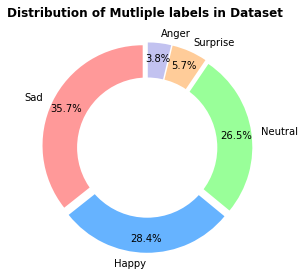

In [22]:
# Pie chart representing dataset distribution of labels


labels = ['Sad', 'Happy', 'Neutral', 'Surprise','Anger']
sizes = [13616, 10825, 10105, 2187, 1433]

#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0']

#explsion
explode = (0.05,0.05,0.05,0.05,0.05)

plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle

plt.title("Distribution of Mutliple labels in Dataset " ,fontweight='bold')
plt.tight_layout()
plt.show()

In [23]:
# Function for implementing model on single sentence input

def get_sentiment(model,text):
    text = clean_text(text)
    #tokenize
    twt = token.texts_to_sequences([text])
    twt = sequence.pad_sequences(twt, maxlen=max_len, dtype='int32')
    sentiment = model.predict(twt,batch_size=1,verbose = 2)
    sent = np.round(np.dot(sentiment,100).tolist(),0)[0]
    result = pd.DataFrame([sent_to_id.keys(),sent]).T
    result.columns = ["sentiment","percentage"]
    result=result[result.percentage != None]

    return result

In [24]:
# Function for Plotting 


def plot_result(df):
    #colors=['#D50000','#000000','#008EF8','#F5B27B','#EDECEC','#D84A09','#019BBD','#FFD000','#7800A0','#098F45','#807C7C','#85DDE9','#F55E10']

    labels = ['Sad', 'Happy', 'Neutral', 'Surprise','Anger']
    colors={'sad':'rgb(64,224,208)','happy':'rgb(100,149,237)',
                    'neutral':'rgb(138,43,226)','surprise':'rgb(221,160,221)',
                    'anger':'rgb(255,218,185)'}
    col_2={}
    for i in result.sentiment.to_list():
        col_2[i]=colors[i]
    fig = px.pie(df, values='percentage', names='sentiment',color='sentiment',color_discrete_map=col_2,hole=0.3)

    fig.show()

#### Encoding and Splitting the dataset  

In [25]:
# Label Encoding Manually 
sent_to_id  = {"sad":0, "happy":1,"neutral":2,"surprise":3,"anger":4}

In [26]:
# Creating column for label encoded data
text_data["sentiment_id"] = text_data['sentiment'].map(sent_to_id)

In [27]:
# One hot encoding the sentiment ID column
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(text_data.sentiment_id)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
Y = onehot_encoder.fit_transform(integer_encoded)

In [28]:
# Test Train Shuffle for training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(text_data.clean_content,Y, random_state=1995, test_size=0.15, shuffle=True)

## LSTM Model

##### NOTE : Model training and related fileds are commented out since we saved the model and using saved model for calculations

In [29]:
# Building LSTM Model for the text model

# Using keras tokenizer here for converting dataset to vector
token = text.Tokenizer(num_words=None)
max_len = 160
Epoch = 10
batch_size = 32
token.fit_on_texts(list(X_train) + list(X_test))
X_train_pad = sequence.pad_sequences(token.texts_to_sequences(X_train), maxlen=max_len)
X_test_pad = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=max_len)
w_idx = token.word_index

In [30]:
# Model summary 

embed_dim = 160
lstm_out = 250

model_text = Sequential()
model_text.add(Embedding(len(w_idx) +1 , embed_dim,input_length = X_test_pad.shape[1]))
model_text.add(SpatialDropout1D(0.2))
model_text.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model_text.add(keras.layers.core.Dense(5, activation='softmax'))
#adam rmsprop 
model_text.compile(loss = "categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])
print(model_text.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 160, 160)          4705120   
                                                                 
 spatial_dropout1d (SpatialD  (None, 160, 160)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 250)               411000    
                                                                 
 dense (Dense)               (None, 5)                 1255      
                                                                 
Total params: 5,117,375
Trainable params: 5,117,375
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Fitting Model 
model_text.fit(X_train_pad, y_train, epochs = Epoch, batch_size=batch_size,validation_data=(X_test_pad, y_test))

Epoch 1/10
 122/1014 [==>...........................] - ETA: 22:29 - loss: 1.3679 - accuracy: 0.3622

In [ ]:
# Confusion Matrix on Validation Set for LSTM Model

num_of_classess = 5

prediction_text = (model_text.predict(X_test_pad))

a = np.argmax(y_test, axis=1)
b = np.argmax(prediction_text, axis=1)

labels = ['Sad', 'Happy', 'Neutral', 'Surprise','Anger']
cm = confusion_matrix(a,b )

plt.figure(figsize = (10,10))
plt.title("Heatmap for Validation set")
sns.heatmap(cm, annot=True, xticklabels =  labels,yticklabels = labels, annot_kws={"size": 12},fmt='g',cmap ='Paired') # font size 
plt.show()

In [ ]:
# Testing on Sentences
testing = "I am happy with my life"
result =get_sentiment(model_text,testing)
print(f'Sentence : {testing} \n {result} {plot_result(result)}')


## LSTM with Glove 

In [ ]:
# https://nlp.stanford.edu/projects/glove/
# Downloaded the word embeddings from glove website 
# Function to read the GLOVE file and find the words  
def read_data(file_name):
    with open(file_name,'r') as f:
        word_vocab = set() 
        word2vector = {}
        for line in f:
            line_ = line.strip() 
            words_Vec = line_.split()
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [ ]:
# Loading the Glove file 

vocab, word_to_idx =read_data("/content/drive/MyDrive/Emotional_messenger/text/glove.twitter.27B.200d.txt")

In [ ]:
# Embedding the sentences with 0's
embedding_matrix = np.zeros((len(w_idx) + 1, 200))
for word, i in w_idx.items():
    embedding_vector = word_to_idx.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embed_dim = 200
lstm_out = 250

model_lstm_gwe = Sequential()
model_lstm_gwe.add(Embedding(len(w_idx) +1 , embed_dim,input_length = X_test_pad.shape[1],weights=[embedding_matrix],trainable=False))
model_lstm_gwe.add(SpatialDropout1D(0.2))
model_lstm_gwe.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model_lstm_gwe.add(keras.layers.core.Dense(5, activation='softmax'))
#adam rmsprop 
model_lstm_gwe.compile(loss = "categorical_crossentropy", optimizer='adam',metrics = ['accuracy'])
print(model_lstm_gwe.summary())

In [ ]:
# Fitting Model 
model_lstm_gwe.fit(X_train_pad, y_train, epochs = Epoch, batch_size=batch_size,validation_data=(X_test_pad, y_test))

In [ ]:
# Testing on Sentences
testing = "I am happy with my life"
result =get_sentiment(model_lstm_gwe,testing)
print(f'Sentence : {testing} \n {result} {plot_result(result)}')


In [ ]:
# Confusion Matrix on Validation Set for LSTM + Glove Model

num_of_classess = 5

prediction_text = (model_lstm_gwe.predict(X_test_pad))

a = np.argmax(y_test, axis=1)
b = np.argmax(prediction_text, axis=1)

labels = ['Sad', 'Happy', 'Neutral', 'Surprise','Anger']
cm = confusion_matrix(a,b )

plt.figure(figsize = (10,10))
plt.title("Heatmap for Validation set")
sns.heatmap(cm, annot=True, xticklabels =  labels,yticklabels = labels, annot_kws={"size": 12},fmt='g',cmap ='Paired') # font size 
plt.show()

#### Saving the Models

In [ ]:
# Saving LSTM Model 

model_text.save('/content/drive/MyDrive/Emotional_messenger/text/saved_model/my_model')

In [ ]:
# Saving LSTM+Glove Model 

model_lstm_gwe.save('/content/drive/MyDrive/Emotional_messenger/text/saved_model_glove/my_model_glove')

#### Loading saved models

In [ ]:
# Loading Saved Model 

# model_text = tf.keras.models.load_model('/content/drive/MyDrive/Emotional_messenger/text/saved_model/my_model')

In [ ]:
# Loading LSTM+Glove Model 

# model_lstm_gwe = tf.keras.models.load_model('/content/drive/MyDrive/Emotional_messenger/text/saved_model_glove/my_model_glove')

In [ ]:
# Final Testing of Loaded Model

In [ ]:
# Testing the model loaded, Glove is having higher accuracy so we will be using GLove model

# Testing on Sentences
testing = "I hate Vancouver"
result =get_sentiment(model_lstm_gwe,testing)
print(f'Sentence : {testing} \n {result} {plot_result(result)}')




## Phase II - Emotion detection using Image dataset FER2013

In [ ]:
# Installing Dependencies

!pip install opencv-python-headless==4.1.2.30
!pip install SpeechRecognition
!pip install comtypes
!pip3 install gTTS pyttsx3 playsound                                              # https://github.com/nateshmbhat/pyttsx3
!apt-get update && sudo apt-get install espeak

In [ ]:
# import dependencies for Sound and Speech Output
from IPython.display import display, Javascript, Image                            # https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html
from google.colab.output import eval_js                                           # https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb
from base64 import b64decode, b64encode
from playsound import playsound                                                   # https://github.com/TaylorSMarks/playsound
import cv2                                                                        # https://github.com/opencv/opencv-python

import os
import time
import PIL
import io
import html
import pyttsx3
import datetime
import random
import imageio 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('white')

# Model loading and Training
from PIL import Image
from skimage import io                                                            # https://scikit-image.org/
from sklearn import svm
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import recall_score,precision_score,f1_score,accuracy_score  # https://scikit-learn.org/stable/
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator               # https://www.tensorflow.org/
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from keras.layers.convolutional import Conv2D                                     # https://keras.io/
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1, l2



In [ ]:
# Loading Dataset - Train and test

df = pd.read_csv('/content/drive/MyDrive/Emotional_messenger/face/train.csv')
df.columns = [col.replace(" ", "") for col in df.columns]
df_test = pd.read_csv('/content/drive/MyDrive/Emotional_messenger/face/test.csv')
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=25)


In [ ]:
# Splitting dataset in columns

X_train = []
y_train = []
for index, row in training_data.iterrows():
    k = row['pixels'].split(" ")
    
    X_train.append(np.array(k))
    y_train.append(row['emotion'])
X_test = []
y_test = []
for index, row in testing_data.iterrows():
    k = row['pixels'].split(" ")
    
    X_test.append(np.array(k))
    y_test.append(row['emotion'])
    
    

In [ ]:
# Converting to integer type values

X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [ ]:
# Converting labels to categorical values and training data to tensor
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
# Extending dataset with data augmentation 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')
testgen = ImageDataGenerator(rescale=1./255)
datagen.fit(X_train)
batch_size = 64

train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

In [ ]:
# Creating final CNN Model

def FER_Model(input_shape=(48,48,1)):
    # first input model
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model 
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())
    
    return model

In [ ]:
# Model definition
model_face = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model_face.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
# Training Model 

num_epochs =   50
history = model_face.fit_generator(train_flow, 
                    steps_per_epoch=len(X_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

In [ ]:
# Saving model 

model_face.save('/content/drive/MyDrive/Emotional_messenger/face/saved_model/my_model')

In [ ]:
# Loading Model

# model_face = tf.keras.models.load_model('/content/drive/MyDrive/Emotional_messenger/face/saved_model/my_model')

####Face Recognition using Javascript

In [ ]:
# Creating object for taking photo and video in the frame

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    var textdata;
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      
      
     
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<button type="button">Send Text!</button>';
      
      instruction.onclick = () => {shutdown = true; };
      div.appendChild(instruction);
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result
              };
    }
    ''')

  display(js)
#  return(JSON.stringify(js))
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# function to convert the JavaScript object into an OpenCV image #https://jfine-python-classes.readthedocs.io/en/latest/javascript-objects.html
# https://docs.opencv.org/3.4/d5/d10/tutorial_js_root.html

def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# Main function to read video and converting it to csv using opencv and then predicting the emotion using model_face
video_stream()

totalprob=[]
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
counter = 0 
count=0
model = model_face
# model.load_weights('model.h5')
# model = load_model('static\Fer2013.h5')
face_haar_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
t_end = time.time() + 10
while time.time() < t_end:
    js_reply = video_frame(label_html, bbox)
    
    
    if not js_reply:
        break
    
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    
    if (counter==0):
      val = input("Enter the text message: ")
      print(val)
      counter+=1
    
    height, width , channel = img.shape
    sub_img = img[0:int(height/6),0:int(width)]
    bbox_array = np.ones(sub_img.shape, dtype=np.uint8)*0
    black_rect = np.ones(sub_img.shape, dtype=np.uint8)*0
    res = cv2.addWeighted(sub_img, 0.77, bbox_array,0.23, 0)
    FONT = cv2.FONT_HERSHEY_SIMPLEX
    FONT_SCALE = 0.8
    FONT_THICKNESS = 2
    lable_color = (10, 10, 255)
    lable = "Emotion Detection made by Nikita & Animesh"
    lable_dimension = cv2.getTextSize(lable,FONT ,FONT_SCALE,FONT_THICKNESS)[0]
    textX = int((res.shape[1] - lable_dimension[0]) / 2)
    textY = int((res.shape[0] + lable_dimension[1]) / 2)
    cv2.putText(res, lable, (textX,textY), FONT, FONT_SCALE, (0,0,0), FONT_THICKNESS)
    gray_image= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_haar_cascade.detectMultiScale(gray_image )
    for (x,y,w,h) in faces:
      cv2.rectangle(bbox_array, pt1 = (x,y),pt2 = (x+w, y+h), color = (255,0,0),thickness =  2)
      roi_gray = gray_image[y-5:y+h+5,x-5:x+w+5]
      roi_gray=cv2.resize(roi_gray,(48,48))
      image_pixels = img_to_array(roi_gray)
      image_pixels = np.expand_dims(image_pixels, axis = 0)
      image_pixels /= 255
      predictions = model.predict(image_pixels)
      totalprob.append(predictions)
      max_index = np.argmax(predictions[0])
      #print(totalprob)
      emotion_detection = ('angry', 'angry', 'surprise', 'happy', 'sad', 'surprise', 'neutral')
      emotion_prediction = emotion_detection[max_index]
      
      #print(predictions)
      cv2.putText(res, "Sentiment: {}".format(emotion_prediction), (0,textY+22+5), FONT,0.7, lable_color,2)
      lable_violation = 'Confidence: {}'.format(str(np.round(np.max(predictions[0])*100,1))+ "%")
      violation_text_dimension = cv2.getTextSize(lable_violation,FONT,FONT_SCALE,FONT_THICKNESS )[0]
      violation_x_axis = int(res.shape[1]- violation_text_dimension[0])
      cv2.putText(res, lable_violation, (violation_x_axis,textY+22+5), FONT,0.7, lable_color,2)
    #pp=(js_video)
    bbox_array[0:int(height/6),0:int(width)] = res
    
    # convert overlay of bbox into bytes
 

# print(predictions)
label_html1 = 'Capturing completed'
js_reply = video_frame(label_html1, bbox)
cv2.destroyAllWindows


In [ ]:
# Creating a zero list for saving result
av=[0,0,0,0,0,0,0]
#print(len(totalprob))
for i in range(0,len(totalprob)):
  for j in range(0,7):
    av[j]=totalprob[i][0][j]+av[j]
for k in range(0,len(av)):
  av[k]=av[k]/(len(totalprob))
emotion_detection = ('angry','happy', 'sad', 'surprise', 'neutral')
del av[1]
del av[1]

max_index = np.argmax(av)
dfemotion = pd.DataFrame(av)
dfemotion['label']=emotion_detection
print(f' Face Emotion Detection result : {emotion_detection[max_index]}')
result_camera = dfemotion.copy()


## Phase III - Adding both Text and Face Analysis to generate the resulting Emotion and narrating the output

In [ ]:
# Finding result on text sentence using LSTM + Glove Model and Video output using CNN Model

result_text = get_sentiment(model_lstm_gwe,val)
result_face = result_camera.copy()

# Creating a new DataFrame to store final result
final_output = result_text

In [ ]:
# print(result_text , result_face)

In [ ]:
# Adding Result for both the models with a weightage of Face = 0.8 and Text = 0.2 percentage

import numpy as np
sum = []
def Average(r1,r2):
    for i in range(len(r1)):
        a = ( (r1.loc[i][1]) * 0.2 + ((r2.loc[i][0]*100)) * 1.8 ) /2
        sum.append(a)
    return sum


res = Average(result_text,result_face) 

k = 0
for i in res:
    final_output.iloc[k][1] = res[k]
    k+=1
# final_output

In [ ]:
# Final Emotion from both the Models
choose=final_output.loc[final_output['percentage']==final_output['percentage'].max()]
print(f' Choosen Emotion from Both Models : {choose.sentiment}')


In [ ]:
# Modified plotting function for 1 entry
def plot_result1(df):
    #colors=['#D50000','#000000','#008EF8','#F5B27B','#EDECEC','#D84A09','#019BBD','#FFD000','#7800A0','#098F45','#807C7C','#85DDE9','#F55E10']

    labels = ['Sad', 'Happy', 'Neutral', 'Surprise','Anger']
    colors={'sad':'rgb(64,224,208)','happy':'rgb(100,149,237)',
                    'neutral':'rgb(138,43,226)','surprise':'rgb(221,160,221)',
                    'anger':'rgb(255,218,185)'}
    col_2={}
    for i in final_output.sentiment.to_list():
        col_2[i]=colors[i]
    fig = px.pie(df, values='percentage', names='sentiment',color='sentiment',color_discrete_map=col_2,hole=0.3)

    fig.show()

# Result : Emotion Pie Chart and Narrated Output

In [ ]:
print(f'Sentence : {val}. \n Emotion :{choose.sentiment} {plot_result1(final_output)}')

### Output with tone of the resulting emotion

In [ ]:
# Playing the text in speech with tone # https://librosa.org/doc/latest/index.html

import IPython.display as ipd
import gtts

# make request to google to get synthesis
tts = gtts.gTTS(val)

# save the audio file
tts.save("/content/drive/MyDrive/Emotional_messenger/string.mp3")
ipd.Audio('/content/drive/MyDrive/Emotional_messenger/string.mp3') # load a local WAV file